<a href="https://colab.research.google.com/github/riyas036/Audio-Data-Preparation-and-Augmentation-Application/blob/main/Audio_Data_Preparation_and_Augmentation_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow IO Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Audio Data Preparation and Augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/io/tutorials/audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/io/blob/master/docs/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
      <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/io/docs/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

One of the biggest challanges in Automatic Speech Recognition is the preparation and augmentation of audio data. Audio data analysis could be in time or frequency domain, which adds additional complex compared with other data sources such as images.

As a part of the TensorFlow ecosystem, `tensorflow-io` package provides quite a few useful audio-related APIs that helps easing the preparation and augmentation of audio data.

## Setup

### Install required Packages, and restart runtime

In [ ]:
!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 26.3 MB/s eta 0:00:00


## Usage

### Read an Audio File

In TensorFlow IO, class `tfio.audio.AudioIOTensor` allows you to read an audio file into a lazy-loaded `IOTensor`:

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

print(audio)

<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>


In the above example, the Flac file `brooklyn.flac` is from a publicly accessible audio clip in [google cloud](https://cloud.google.com/speech-to-text/docs/quickstart-gcloud).

The GCS address `gs://cloud-samples-tests/speech/brooklyn.flac` are used directly because GCS is a supported file system in TensorFlow. In addition to `Flac` format, `WAV`, `Ogg`, `MP3`, and `MP4A` are also supported by `AudioIOTensor` with automatic file format detection.

`AudioIOTensor` is lazy-loaded so only shape, dtype, and sample rate are shown initially. The shape of the `AudioIOTensor` is represented as `[samples, channels]`, which means the audio clip you loaded is mono channel with `28979` samples in `int16`.

The content of the audio clip will only be read as needed, either by converting `AudioIOTensor` to `Tensor` through `to_tensor()`, or though slicing. Slicing is especially useful when only a small portion of a large audio clip is needed:

In [ ]:
audio_slice = audio[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


The audio can be played through:

In [ ]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

It is more convinient to convert tensor into float numbers and show the audio clip in graph:

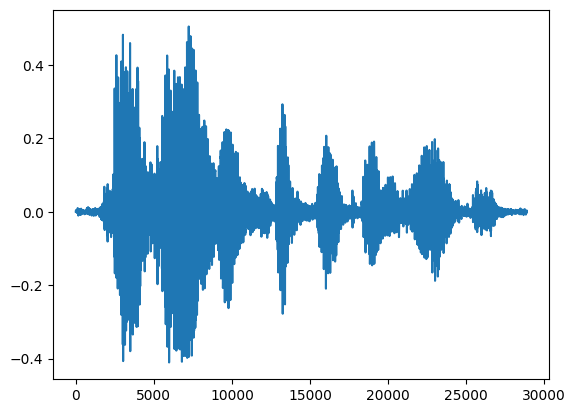

In [ ]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

### Trim the noise

Sometimes it makes sense to trim the noise from the audio, which could be done through API `tfio.audio.trim`. Returned from the API is a pair of `[start, stop]` position of the segement:

tf.Tensor([ 2398 23546], shape=(2,), dtype=int64)
tf.Tensor(2398, shape=(), dtype=int64) tf.Tensor(23546, shape=(), dtype=int64)


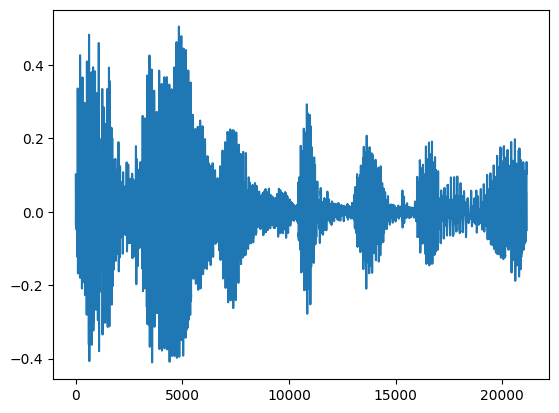

In [ ]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

### Fade In and Fade Out

One useful audio engineering technique is fade, which gradually increases or decreases audio signals. This can be done through `tfio.audio.fade`. `tfio.audio.fade` supports different shapes of fades such as `linear`, `logarithmic`, or `exponential`:

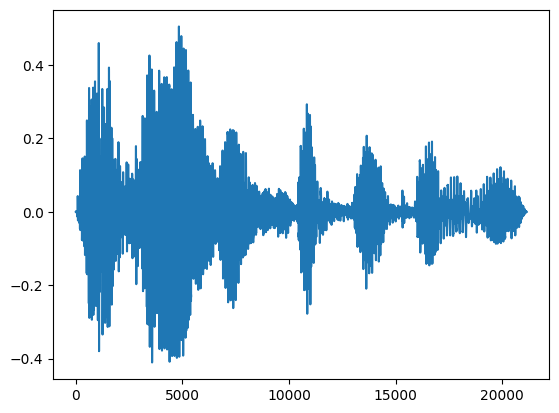

In [ ]:
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

### Spectrogram

Advanced audio processing often works on frequency changes over time. In `tensorflow-io` a waveform can be converted to spectrogram through `tfio.audio.spectrogram`:

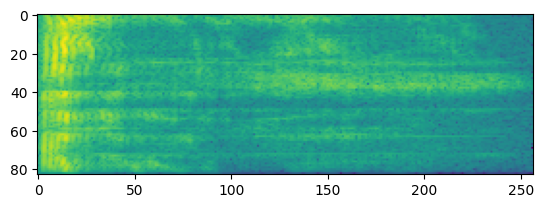

In [ ]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

Additional transformation to different scales are also possible:

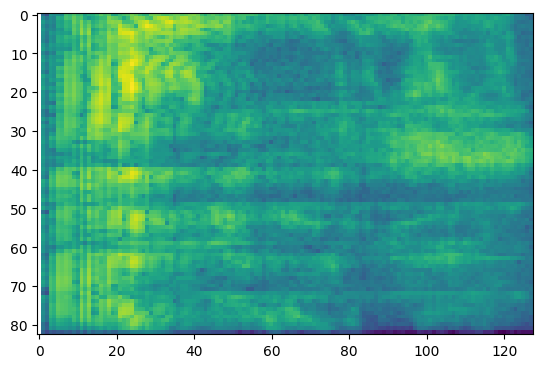

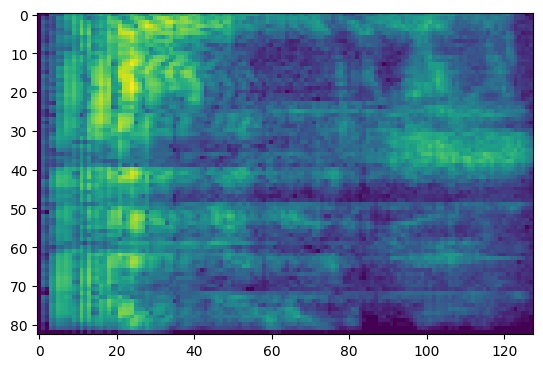

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

### SpecAugment

In addition to the above mentioned data preparation and augmentation APIs, `tensorflow-io` package also provides advanced spectrogram augmentations, most notably Frequency and Time Masking discussed in [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition (Park et al., 2019)](https://arxiv.org/pdf/1904.08779.pdf).

#### Frequency Masking

In frequency masking, frequency channels `[f0, f0 + f)` are masked where `f` is chosen from a uniform distribution from `0` to the frequency mask parameter `F`, and `f0` is chosen from `(0, ν − f)` where `ν` is the number of frequency channels.

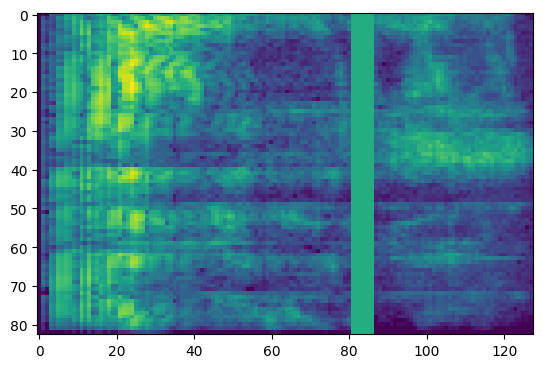

In [ ]:
# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(freq_mask.numpy())

#### Time Masking

In time masking, `t` consecutive time steps `[t0, t0 + t)` are masked where `t` is chosen from a uniform distribution from `0` to the time mask parameter `T`, and `t0` is chosen from `[0, τ − t)` where `τ` is the time steps.

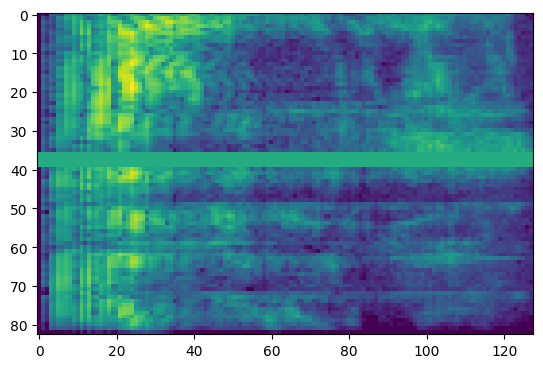

In [ ]:
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(time_mask.numpy())